In [22]:
import torch
import supervision as sv
import transformers
import pytorch_lightning
import os
import random
import torchvision
from transformers import DetrImageProcessor
from matplotlib import pyplot as plt
import random
import cv2
from tqdm import tqdm
from transformers import DetrImageProcessor
import numpy as np


In [10]:
# ---------------- CONFIGURATION ----------------
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

DATASET_ROOT = r"dataset_split"          # main dataset folder
ANNOTATION_FILE = "result.json"          # JSON file inside each split folder

TRAIN_DIRECTORY = os.path.join(DATASET_ROOT, "train")
VAL_DIRECTORY   = os.path.join(DATASET_ROOT, "val")
TEST_DIRECTORY  = os.path.join(DATASET_ROOT, "test")
# ------------------------------------------------


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, image_processor):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        image_info = self.coco.loadImgs(self.ids[idx])[0]
        file_name = os.path.basename(image_info["file_name"])  # <-- fixes 'images/' prefix
        image_path = os.path.join(self.root, file_name)
        image = torchvision.io.read_image(image_path).permute(1, 2, 0).numpy()
        anns = self.coco.imgToAnns[self.ids[idx]]

        anns = {"image_id": image_info["id"], "annotations": anns}
        enc = self.proc(images=image, annotations=anns, return_tensors="pt")
        return enc["pixel_values"].squeeze(0), enc["labels"][0]
    
train_dataset = CocoDetection(TRAIN_DIRECTORY, image_processor)
val_dataset   = CocoDetection(VAL_DIRECTORY, image_processor)
test_dataset  = CocoDetection(TEST_DIRECTORY, image_processor)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train samples: 7
Val samples:   2
Test samples:  1


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Total images: 7


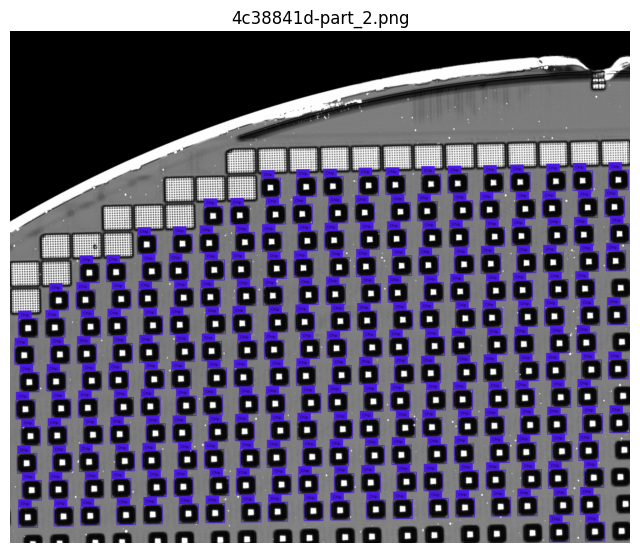

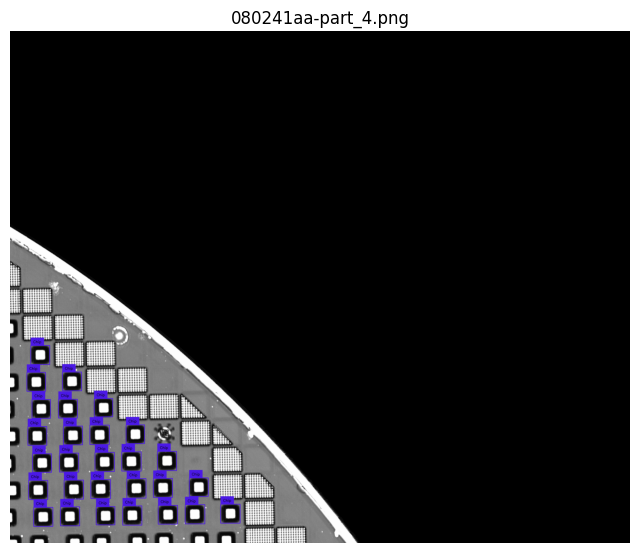

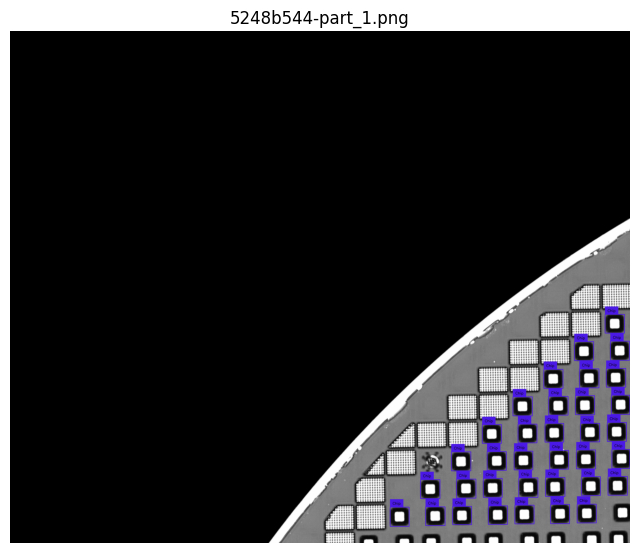

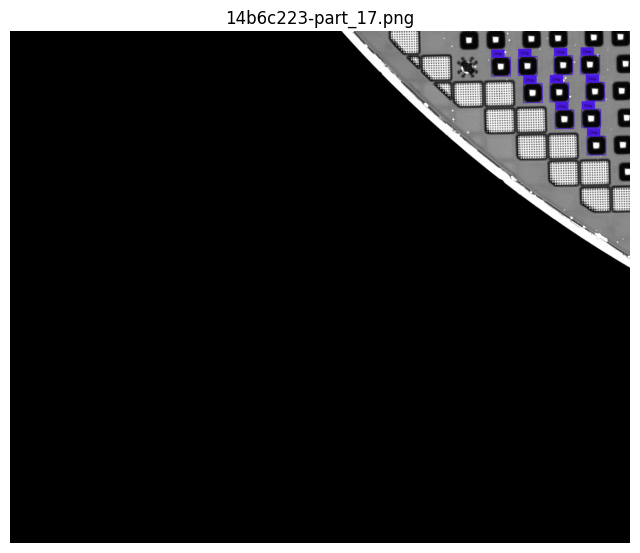

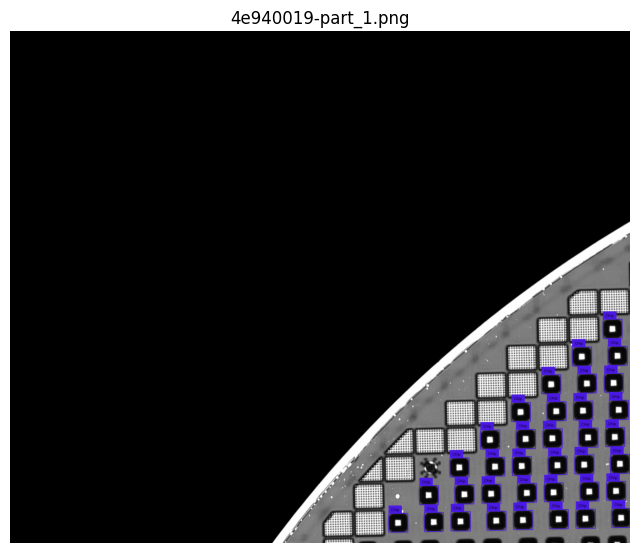

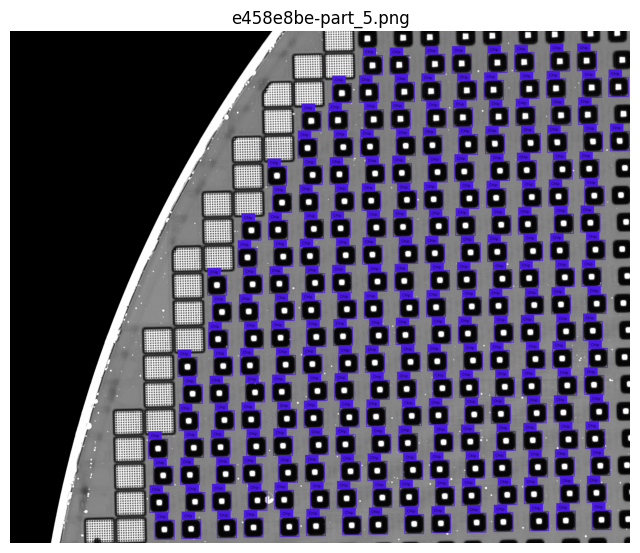

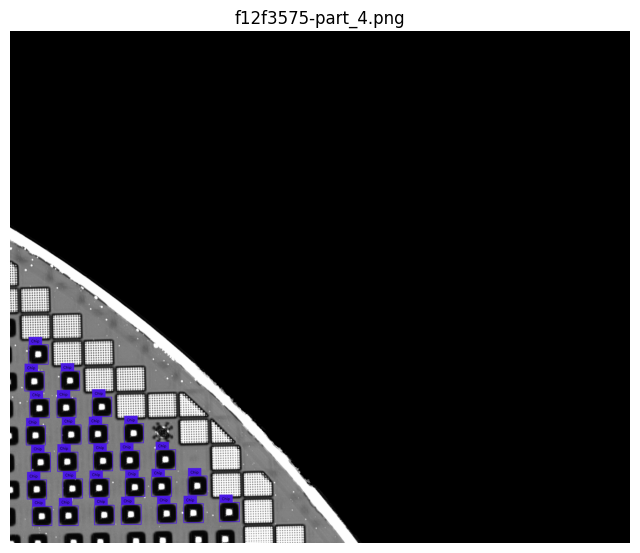

Visualizing images: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


In [11]:
def visualize_all_samples(dataset):
    """
    Visualize all images and annotations in a COCO-format dataset folder.
    Accepts either a path string or a CocoDetection dataset object.
    """
    if isinstance(dataset, str):
        ANNOTATION_FILE = "result.json"
        image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

        class CocoDetection(torchvision.datasets.CocoDetection):
            def __init__(self, image_dir, image_processor):
                ann_path = os.path.join(image_dir, ANNOTATION_FILE)
                super(CocoDetection, self).__init__(image_dir, ann_path)
                self.image_processor = image_processor

        dataset = CocoDetection(dataset, image_processor)

    image_ids = dataset.coco.getImgIds()
    categories = dataset.coco.cats
    id2label = {k: v['name'] for k, v in categories.items()}

    print(f"Total images: {len(image_ids)}")

    for image_id in tqdm(image_ids, desc="Visualizing images"):
        image_info = dataset.coco.loadImgs(image_id)[0]
        annotations = dataset.coco.imgToAnns[image_id]

        file_name = os.path.basename(image_info['file_name'])
        image_path = os.path.join(dataset.root, file_name)

        if not os.path.exists(image_path):
            print(f"Skipping missing image: {image_path}")
            continue

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
        labels = [id2label[class_id] for _, _, class_id, _ in detections]

        box_annotator = sv.BoxAnnotator()
        annotated_image = box_annotator.annotate(scene=image, detections=detections, labels=labels)

        plt.figure(figsize=(8, 8))
        plt.imshow(annotated_image)
        plt.axis("off")
        plt.title(file_name)
        plt.show()
visualize_all_samples("dataset_split/train")


In [14]:


# Paths
DATASET_ROOT = r"dataset_split"
ANNOTATION_FILE = "result.json"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

# Load processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Dataset class
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, image_dir, image_processor):
        ann_path = os.path.join(image_dir, ANNOTATION_FILE)
        super(CocoDetection, self).__init__(image_dir, ann_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        image, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {"image_id": image_id, "annotations": annotations}
        enc = self.image_processor(images=image, annotations=annotations, return_tensors="pt")
        return enc["pixel_values"].squeeze(), enc["labels"][0]

# Create dataset objects
TRAIN_DATASET = CocoDetection(TRAIN_DIR, image_processor)
VAL_DATASET   = CocoDetection(VAL_DIR, image_processor)
TEST_DATASET  = CocoDetection(TEST_DIR, image_processor)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [41]:
import os, torch, torchvision, pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection

def train_detr(
    dataset_root="dataset_split",
    annot_name="result.json",
    batch_size=4,
    epochs=200,
    lr=1e-4,
    lr_backbone=1e-5,
    weight_decay=1e-4,
    num_workers=0,
    accumulate=8,
    grad_clip=0.1,
    log_every=5,
    seed=42,
    gradient_clip_val=0.1

):
    torch.manual_seed(seed)

    # --- Processor ---
    image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    # --- Dataset ---
    class CocoDetection(torchvision.datasets.CocoDetection):
        def __init__(self, img_dir, proc):
            super().__init__(img_dir, os.path.join(img_dir, annot_name))
            self.proc = proc
        def __getitem__(self, idx):
            image, anns = super().__getitem__(idx)
            image_id = self.ids[idx]
            anns = {"image_id": image_id, "annotations": anns}
            enc = self.proc(images=image, annotations=anns, return_tensors="pt")
            return enc["pixel_values"].squeeze(0), enc["labels"][0]

    train_dir = os.path.join(dataset_root, "train")
    val_dir   = os.path.join(dataset_root, "val")
    test_dir  = os.path.join(dataset_root, "test")

    train_ds = CocoDetection(train_dir, image_processor)
    val_ds   = CocoDetection(val_dir, image_processor)
    test_ds  = CocoDetection(test_dir, image_processor)

    # --- id2label / label2id from categories ---
    cats = train_ds.coco.cats
    id2label = {int(k): v["name"] for k, v in cats.items()}
    label2id = {v: k for k, v in id2label.items()}

    # --- Collate ---
    def detr_collate_fn(batch):
        pix = [b[0] for b in batch]
        lab = [b[1] for b in batch]
        enc = image_processor.pad(pix, return_tensors="pt")
        return {"pixel_values": enc["pixel_values"], "pixel_mask": enc["pixel_mask"], "labels": lab}

    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              collate_fn=detr_collate_fn, num_workers=num_workers,
                              pin_memory=pin, persistent_workers=bool(num_workers))
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              collate_fn=detr_collate_fn, num_workers=num_workers,
                              pin_memory=pin, persistent_workers=bool(num_workers))
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                              collate_fn=detr_collate_fn, num_workers=num_workers,
                              pin_memory=pin, persistent_workers=bool(num_workers))

    # --- Lightning module ---
    class DetrLit(pl.LightningModule):
        def __init__(self):
            super().__init__()
            self.model = DetrForObjectDetection.from_pretrained(
                "facebook/detr-resnet-50",
                num_labels=len(id2label),
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True,
            )
        def forward(self, pixel_values, pixel_mask):
            return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        def _step(self, batch, tag):
            pv, pm, labels = batch["pixel_values"], batch["pixel_mask"], [{k:v.to(self.device) for k,v in t.items()} for t in batch["labels"]]
            out = self.model(pixel_values=pv, pixel_mask=pm, labels=labels)
            self.log(f"{tag}/loss", out.loss, prog_bar=True)
            for k, v in out.loss_dict.items():
                self.log(f"{tag}/{k}", v.detach(), prog_bar=False)
            return out.loss
        def training_step(self, batch, _): return self._step(batch, "train")
        def validation_step(self, batch, _): return self._step(batch, "val")
        def configure_optimizers(self):
            param_dicts = [
                {
                    "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad],
                },
                {
                    "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                    "lr": lr_backbone,
                },
            ]

            optimizer = torch.optim.AdamW(param_dicts, lr=lr, weight_decay=weight_decay)

            # === StepLR Scheduler ===
            # Reduces LR by 0.1 every 120 epochs (tunable)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

            # Lightning expects a dict return if using schedulers
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",  # step the scheduler each epoch
                    "frequency": 1,
                },
            }

    model = DetrLit()

    # --- Trainer ---
    trainer = pl.Trainer(
        max_epochs=epochs,
        gradient_clip_val=gradient_clip_val,
        accumulate_grad_batches=accumulate,
        log_every_n_steps=log_every,
    )
    # --- Train ---
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    return model, trainer, (train_loader, val_loader, test_loader)

In [44]:
#from detr_train import train_detr   # assuming you saved the previous code as detr_train.py
#from detr_train import train_detr   # ensure train_detr() function is defined in detr_train.py

if __name__ == "__main__":
    # === Training Configuration ===
    model, trainer, loaders = train_detr(
        dataset_root="dataset_split",       # path to split dataset
        annot_name="result.json",           # COCO JSON inside each folder
        batch_size=4,
        epochs=250,                          # change to 200+ for better convergence
        lr=1e-4,
        lr_backbone=1e-5,
        weight_decay=1e-4,
        num_workers=0,                      # set >0 for faster data loading if CPU allows
        accumulate=8,                       # gradient accumulation steps
        grad_clip=0.1,                      # gradient clipping value
        log_every=5,                        # log frequency     # schedule LR per epoch
        gradient_clip_val=0.1               # Lightning trainer gradient clipping
    )

    print("Training complete.")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\torch\nn\modules\module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\torch\nn\modules\module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\torch\nn\modules\module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\Divyesh Jayswal\Desktop\DETR\detr_venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:527: Found 399 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 249: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=5, train/loss=0.441, val/loss=0.769]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:34<00:00,  0.06it/s, v_num=5, train/loss=0.441, val/loss=0.769]
Training complete.


In [50]:
# after training completes
hf_dir = "detr_finetuned"
model.model.save_pretrained(hf_dir)
image_processor.save_pretrained(hf_dir)

['detr_finetuned\\preprocessor_config.json']

In [47]:
import os, glob, json, csv, torch, cv2
from tqdm import tqdm
from PIL import Image
import transformers
from transformers import DetrImageProcessor, DetrForObjectDetection

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

def _list_images(folder):
    paths = []
    for p in glob.glob(os.path.join(folder, "*")):
        if os.path.isdir(p):
            # include nested subfolders if any
            for root, _, files in os.walk(p):
                for f in files:
                    if f.lower().endswith(IMG_EXTS):
                        paths.append(os.path.join(root, f))
        elif p.lower().endswith(IMG_EXTS):
            paths.append(p)
    return sorted(paths)

def _load_processor(pref):
    try:
        return DetrImageProcessor.from_pretrained(pref)
    except Exception:
        return DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def _load_model(checkpoint_path):
    # If a dir with HF weights
    if os.path.isdir(checkpoint_path):
        model = DetrForObjectDetection.from_pretrained(checkpoint_path)
    else:
        # Lightning .ckpt
        model = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50", ignore_mismatched_sizes=True
        )
        state = torch.load(checkpoint_path, map_location="cpu")
        sd = state.get("state_dict", state)
        sd = {k.replace("model.", "", 1): v for k, v in sd.items()}
        model.load_state_dict(sd, strict=False)
    return model

def infer_folder(
    images_dir,
    output_dir,
    checkpoint_path,                 # HF dir or Lightning .ckpt
    conf_thresh=0.5,
    device=None
):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels"), exist_ok=True)

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # load processor (prefer same dir as model if available)
    processor = _load_processor(checkpoint_path)
    model = _load_model(checkpoint_path)
    model.to(device).eval()

    # labels
    id2label = getattr(model.config, "id2label", None) or {}
    # optional override from a sidecar file (if you saved it)
    sidecar = os.path.join(checkpoint_path, "id2label.json") if os.path.isdir(checkpoint_path) else None
    if sidecar and os.path.exists(sidecar):
        with open(sidecar) as f:
            id2label = {int(k): v for k, v in json.load(f).items()}

    img_paths = _list_images(images_dir)
    if not img_paths:
        raise FileNotFoundError(f"No images found in: {images_dir}")

    csv_path = os.path.join(output_dir, "detections.csv")
    with open(csv_path, "w", newline="") as fcsv:
        writer = csv.writer(fcsv)
        writer.writerow(["filename", "cls_id", "cls_name", "score", "x_min", "y_min", "x_max", "y_max"])

        for p in tqdm(img_paths, desc="Inferring"):
            image = Image.open(p).convert("RGB")
            enc = processor(images=image, return_tensors="pt").to(device)

            with torch.no_grad():
                out = model(**enc)

            results = processor.post_process_object_detection(
                out,
                target_sizes=torch.tensor([image.size[::-1]], device=device),
                threshold=conf_thresh
            )[0]

            # draw using PIL->NumPy to avoid cv2.imread path issues
            img_np = np.array(image)  # RGB
            img_cv = img_np.copy()

            per_image_json = []
            for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
                x0, y0, x1, y1 = [int(v.item()) for v in box]
                cls_id = int(label.item())
                cls_name = id2label.get(cls_id, str(cls_id))
                sc = float(score.item())

                writer.writerow([os.path.basename(p), cls_id, cls_name, f"{sc:.4f}", x0, y0, x1, y1])

                per_image_json.append({
                    "filename": os.path.basename(p),
                    "cls_id": cls_id,
                    "cls_name": cls_name,
                    "score": sc,
                    "bbox_xyxy": [x0, y0, x1, y1]
                })

                cv2.rectangle(img_cv, (x0, y0), (x1, y1), (0, 255, 0), 2)
                text = f"{cls_name}:{sc:.2f}"
                (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                y_text = max(0, y0 - 6)
                cv2.rectangle(img_cv, (x0, y_text - th - 4), (x0 + tw + 4, y_text + 2), (0, 255, 0), -1)
                cv2.putText(img_cv, text, (x0 + 2, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

            # save annotated image
            det_name = os.path.splitext(os.path.basename(p))[0] + "_det.png"
            det_path = os.path.join(output_dir, "images", det_name)
            cv2.imwrite(det_path, cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR))

            # save per-image JSON
            json_path = os.path.join(output_dir, "labels", os.path.splitext(os.path.basename(p))[0] + ".json")
            with open(json_path, "w") as fj:
                json.dump(per_image_json, fj)

    print(f"Saved images → {os.path.join(output_dir,'images')}")
    print(f"Saved JSONs → {os.path.join(output_dir,'labels')}")
    print(f"Saved CSV   → {csv_path}")

In [49]:

infer_folder(
    images_dir=r"dataset_split\test\images",
    output_dir=r"output",
    checkpoint_path=r"detr_finetuned",   # now points to folder, not .ckpt
    conf_thresh=0.89
)

Inferring: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

Saved images → output\images
Saved JSONs → output\labels
Saved CSV   → output\detections.csv
